In [1]:
import xarray as xr
import os
import glob
import dask.distributed as dd
import dask
import dask.array as da
import time
import sys
import calendar
from datetime import datetime, timedelta
import numpy as np
import wrf
from itertools import product

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['text.usetex'] = False

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FixedLocator, FixedFormatter

import cartopy
from cartopy import crs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from matplotlib.cm import get_cmap
import cmaps

from windrose import WindroseAxes

from scipy.stats import weibull_min

import seaborn as sns
import seaborn.objects as so

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator

from scipy.stats import linregress


from meteostat import Stations
from datetime import datetime
from meteostat import Hourly

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope

In [7]:
root_dir = '/media/harish/SSD_4TB/EU_SCORES'

In [16]:
# Writing a function to extract location wise data based on XLAT and XLONG
def read_pointwise_timeseries(ds, target_lat, target_lon, var_name = None,vert_levels=None):
    if 'Time' in ds.coords:
        # If 'Time' is present in the coordinates, select the first time step
        ds_single_time = ds.isel(Time=0)
    else:
        # If 'Time' is not present, use the dataset as is
        ds_single_time = ds
    start = time.time()
    # Calculate the squared distance to each grid point
    distance_squared = (ds_single_time.XLAT - target_lat)**2 + (ds_single_time.XLONG - target_lon)**2
    end = time.time()
    print(f'Time elapsed for nearest point identification is {end-start}s')
    # Find the indices of the nearest grid point
    indices = np.unravel_index(np.nanargmin(distance_squared), distance_squared.shape)
    nearest_indices = {'south_north': indices[0], 'west_east': indices[1]}
    print(nearest_indices)
    # Select the nearest point using the indices
    if var_name:
        if vert_levels:
            var_timeseries = ds[var_name].isel(bottom_top=slice(None,vert_levels),south_north=nearest_indices['south_north'], west_east=nearest_indices['west_east'])
        else:
            var_timeseries = ds[var_name].isel(south_north=nearest_indices['south_north'], west_east=nearest_indices['west_east'])
    else:
        if vert_levels:
            var_timeseries = ds.isel(bottom_top=slice(None,vert_levels),south_north=nearest_indices['south_north'], west_east=nearest_indices['west_east'])
        else:
            var_timeseries = ds.isel(south_north=nearest_indices['south_north'], west_east=nearest_indices['west_east'])
    var_timeseries.name = 'data'
    return var_timeseries

In [47]:
line_styles = ['-','--','-']
colors = [
    'black',  # Light Blue
    'orange',    # Dark Orange
    (102/255, 0/255, 102/255),     # Dark Purple
    (0/255, 153/255, 0/255),      # Dark Green
    (204/255, 0/255, 0/255),      # Dark Red
    (139/255, 69/255, 19/255),    # Saddle Brown
    (51/255, 51/255, 102/255)    # Dark Blue
]
markers = ['o','d','p','s','*','']

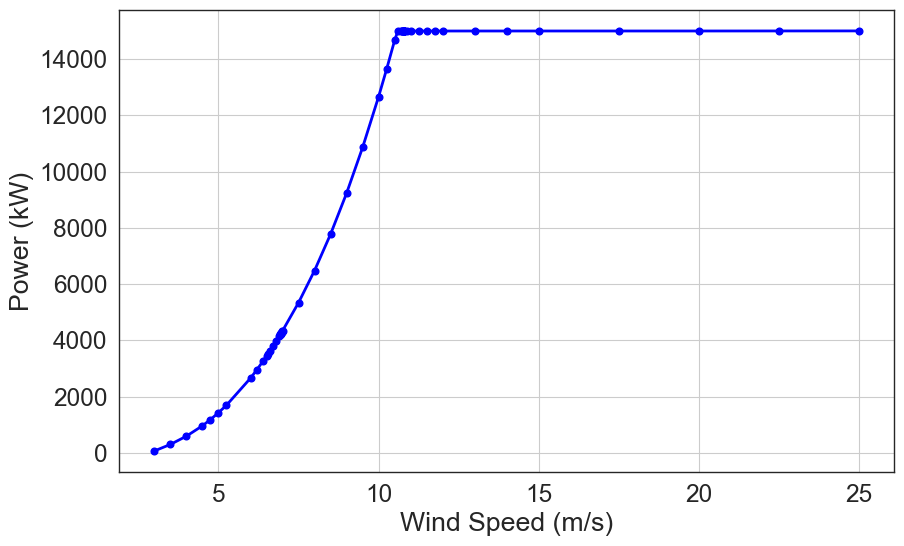

In [7]:
power_curve = pd.read_csv(f'IEA_15MW_240_RWT.csv', usecols=range(0, 2))
# Create a scatter plot of the power curve
sns.set_theme(style="white")
sns.set_context("paper",font_scale=2)
plt.figure(figsize=(10, 6))
plt.plot(power_curve.iloc[:,0], power_curve.iloc[:,1], color='blue', marker='o',linestyle='-',linewidth=2)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
#plt.title('15MW Turbine Power Curve')
plt.grid(True)
#plt.legend()
plt.savefig(f'15MW_turbine_power_curve.png',dpi=300,bbox_inches='tight',pad_inches=0)

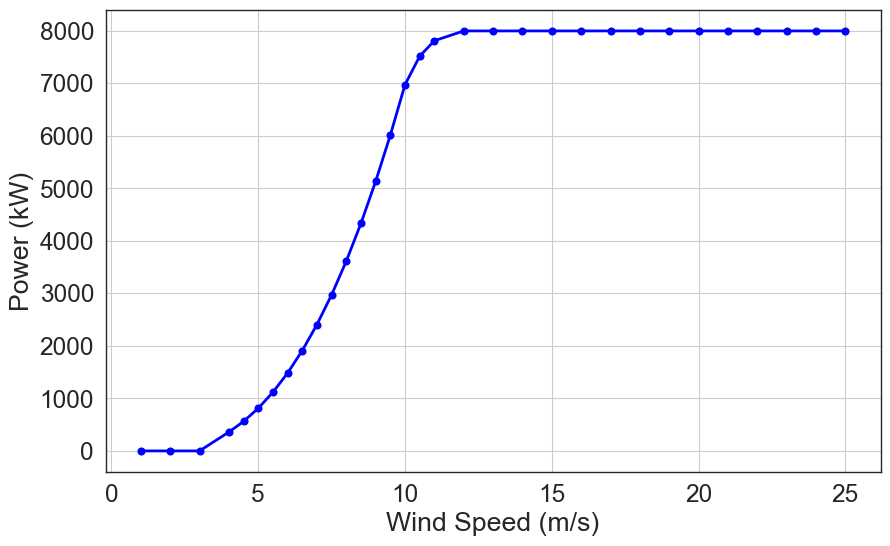

In [8]:
power_curve = pd.read_csv(f'2016CACost_NREL_Reference_8MW_180.csv', usecols=range(0, 2))
# Create a scatter plot of the power curve
sns.set_theme(style="white")
sns.set_context("paper",font_scale=2)
plt.figure(figsize=(10, 6))
plt.plot(power_curve.iloc[:,0], power_curve.iloc[:,1], color='blue', marker='o',linestyle='-',linewidth=2)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
#plt.title('15MW Turbine Power Curve')
plt.grid(True)
#plt.legend()
plt.savefig(f'8MW_turbine_power_curve.png',dpi=300,bbox_inches='tight',pad_inches=0)

In [2]:
def power_profile_plotter(gs,data,title,xlabel,ylabel,label,color,marker,xlabel_ticks=None,legend=None):
    ax = fig.add_subplot(gs)
    #sns.lineplot(x=x, y=y, data=data, ax=ax,lw=2,label=label,legend=legend,color=color,marker=marker,markersize=8)
    
    for i, key in enumerate(data):
        sns.lineplot(x=data.index.name, y=key, data=data, ax=ax, lw=2, label=key, legend=legend, color=colors[i], marker=markers[i], markersize=8)
    
    ax.set_title(title,fontsize=14)
    ax.set_xlabel(xlabel,fontsize=14)
    ax.set_ylabel(ylabel,fontsize=14)
    
    # Set x and y ticks font size
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)  

    # Set x-axis range
    ax.set_xlim([data.index.min(), data.index.max()])

    if xlabel_ticks is not None:
        ax.set_xticks(data.index)
        ax.set_xticklabels(xlabel_ticks)
    
    return ax

### Portugal coast

In [61]:
start='2020-02-01 00:00:00'
end='2020-02-07 00:00:00'
all_sample_points = {}

In [62]:
all_sample_points['Portugal_coast'] = {
    "P1": (41.35, -8.9),
    "P2": (41.5236, -9.055), #P2 is POR2 in tslist
    "P3": (41.7, -9.2),
}
all_sample_points['Netherlands_coast'] = {
    "P1": (51.3, 2.3),
    "P2": (51.6, 2.6), #P2 is POR2 in tslist
    "P3": (51.75, 3.25),
}
all_sample_points['Ireland_coast'] = {
    "P1": (52.55,-10.25),
    "P2": (52.85, -10), #P2 is POR2 in tslist
    "P3": (52.9, -10.4),
}

Time elapsed for nearest point identification is 0.00863957405090332s
{'south_north': 26, 'west_east': 79}
Time elapsed for nearest point identification is 0.00986933708190918s
{'south_north': 64, 'west_east': 54}
Time elapsed for nearest point identification is 0.011092662811279297s
{'south_north': 102, 'west_east': 31}
Time elapsed for nearest point identification is 0.005554914474487305s
{'south_north': 26, 'west_east': 79}
Time elapsed for nearest point identification is 0.012132644653320312s
{'south_north': 64, 'west_east': 54}
Time elapsed for nearest point identification is 0.010750293731689453s
{'south_north': 102, 'west_east': 31}
Time elapsed for nearest point identification is 0.005291938781738281s
{'south_north': 26, 'west_east': 79}
Time elapsed for nearest point identification is 0.010107994079589844s
{'south_north': 64, 'west_east': 54}
Time elapsed for nearest point identification is 0.010671615600585938s
{'south_north': 102, 'west_east': 31}
Time elapsed for nearest po

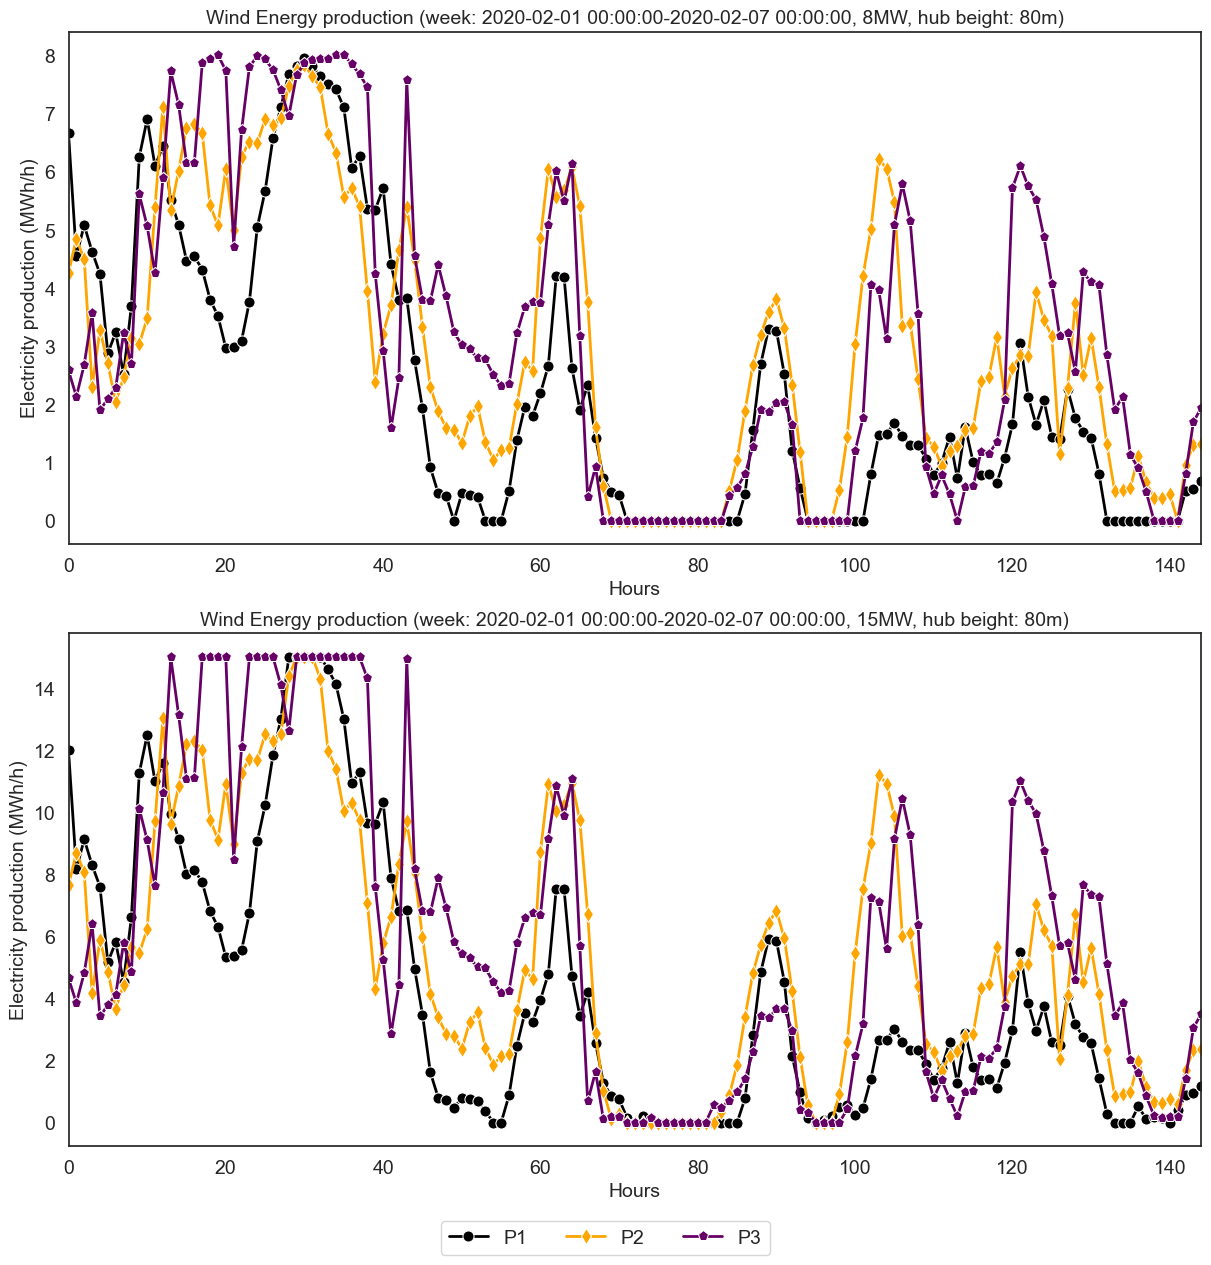

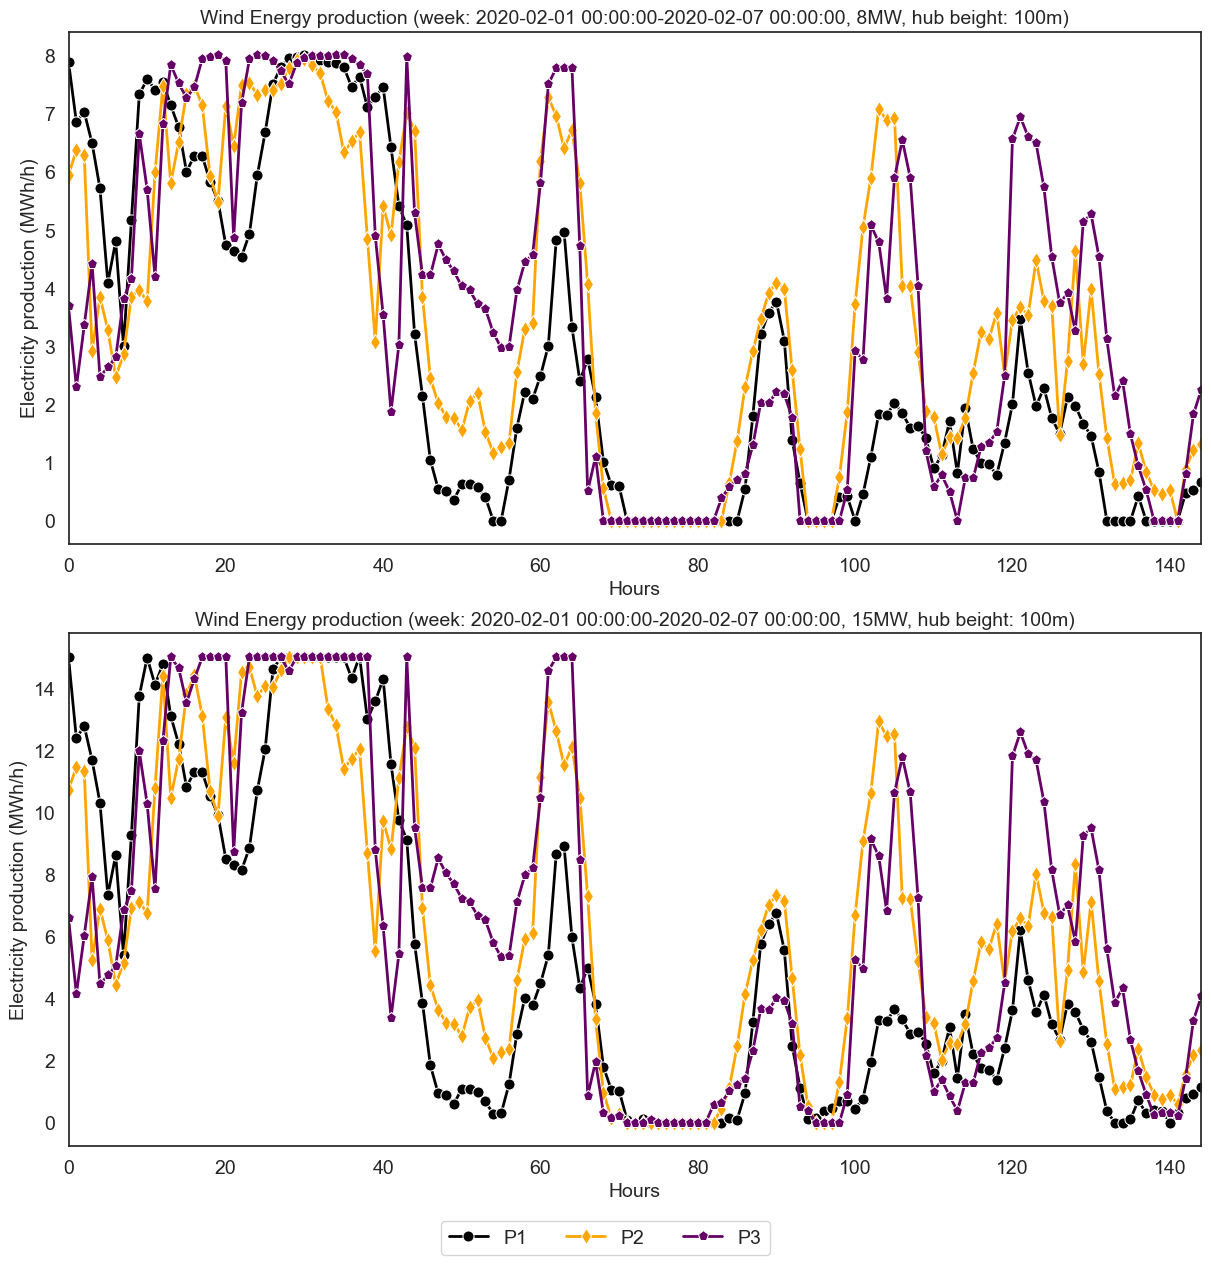

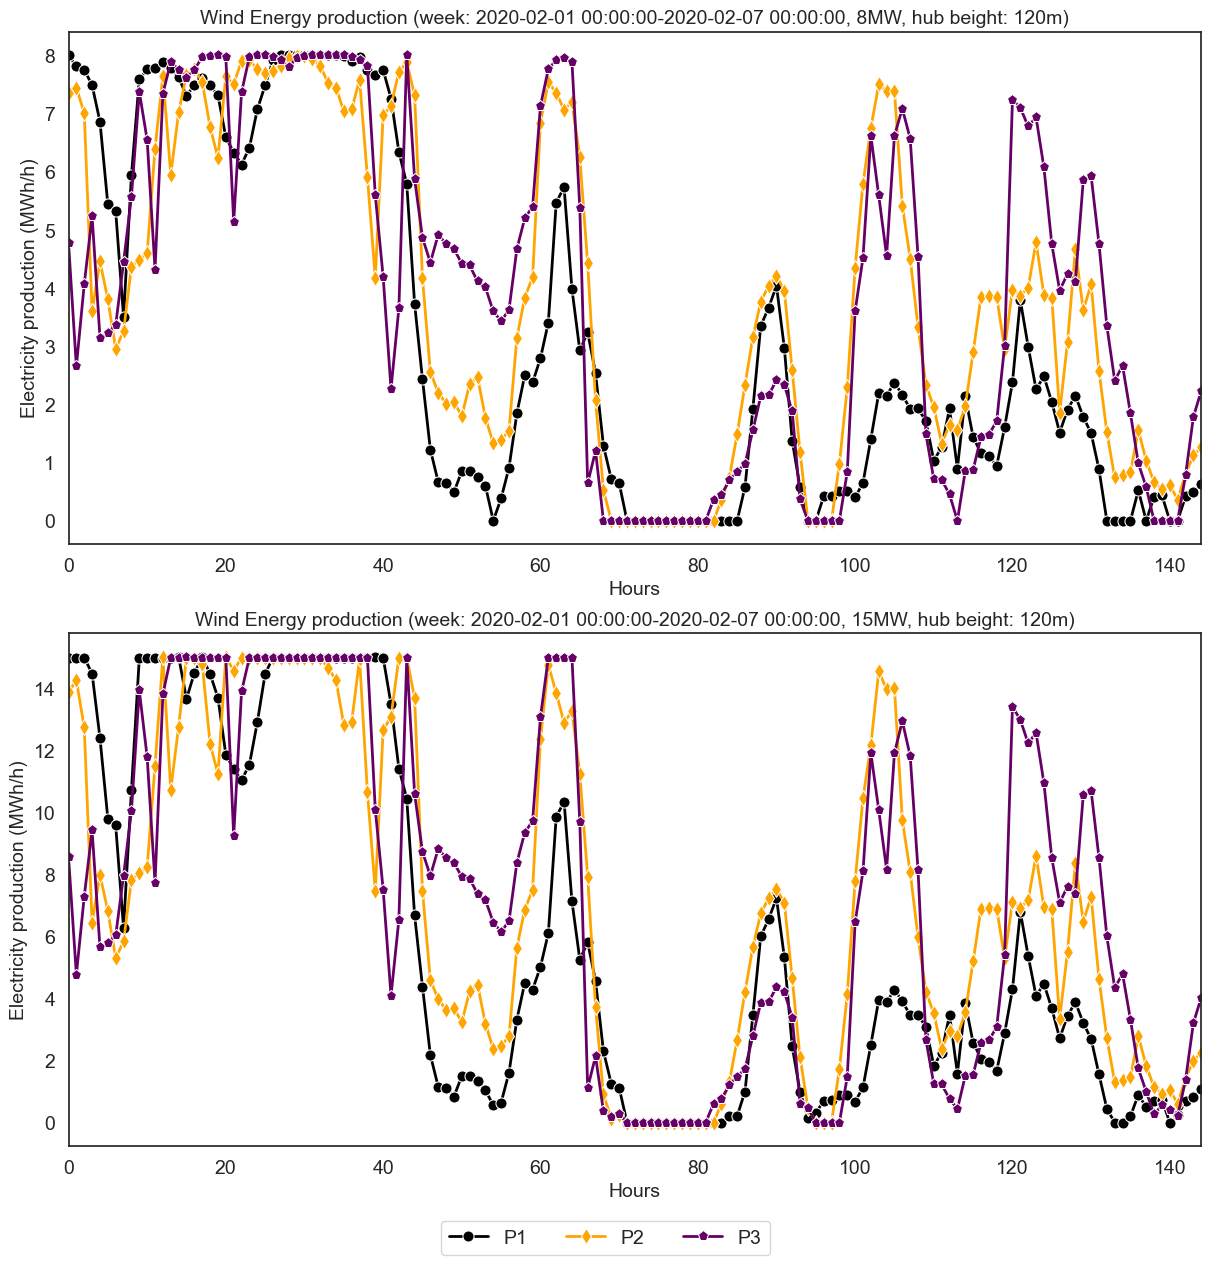

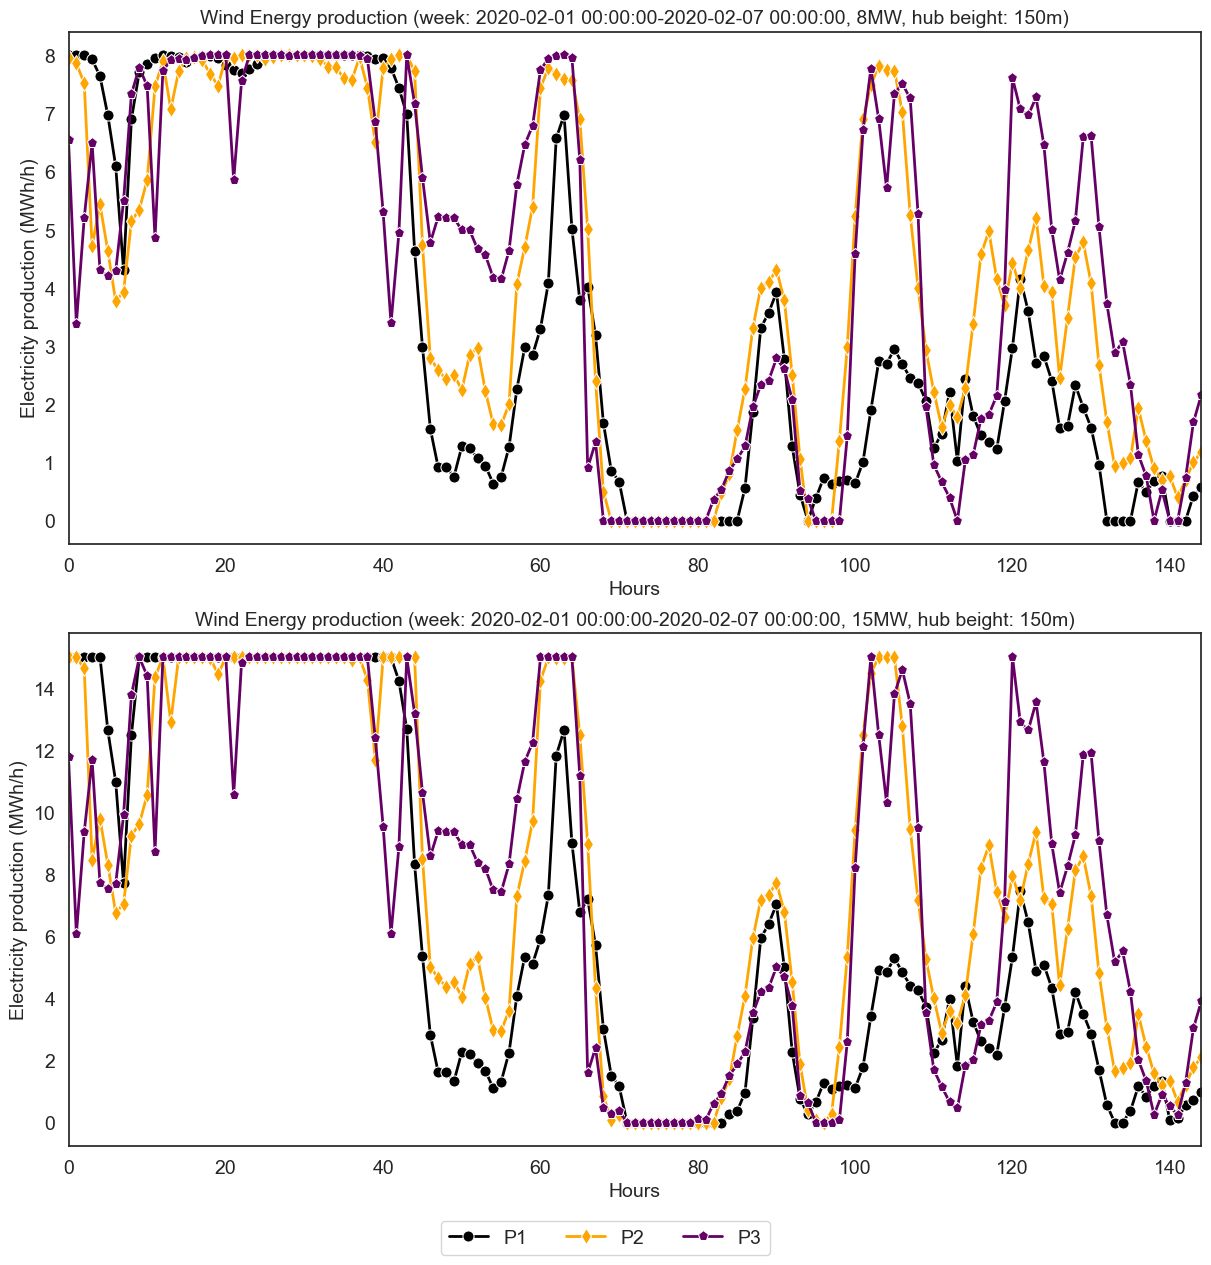

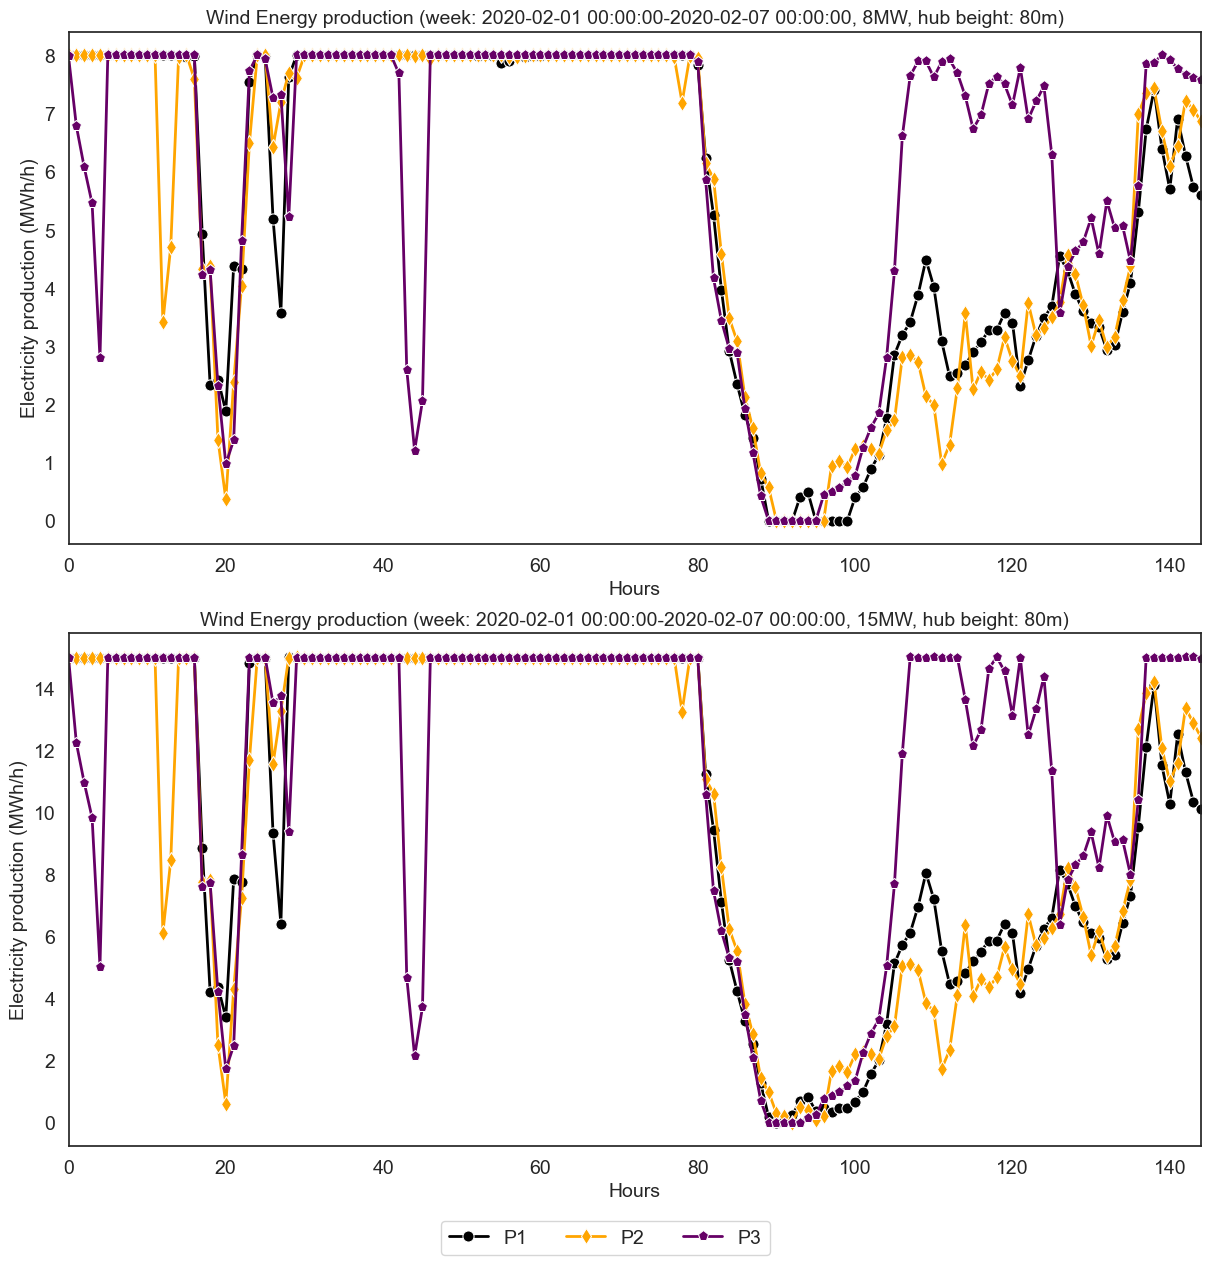

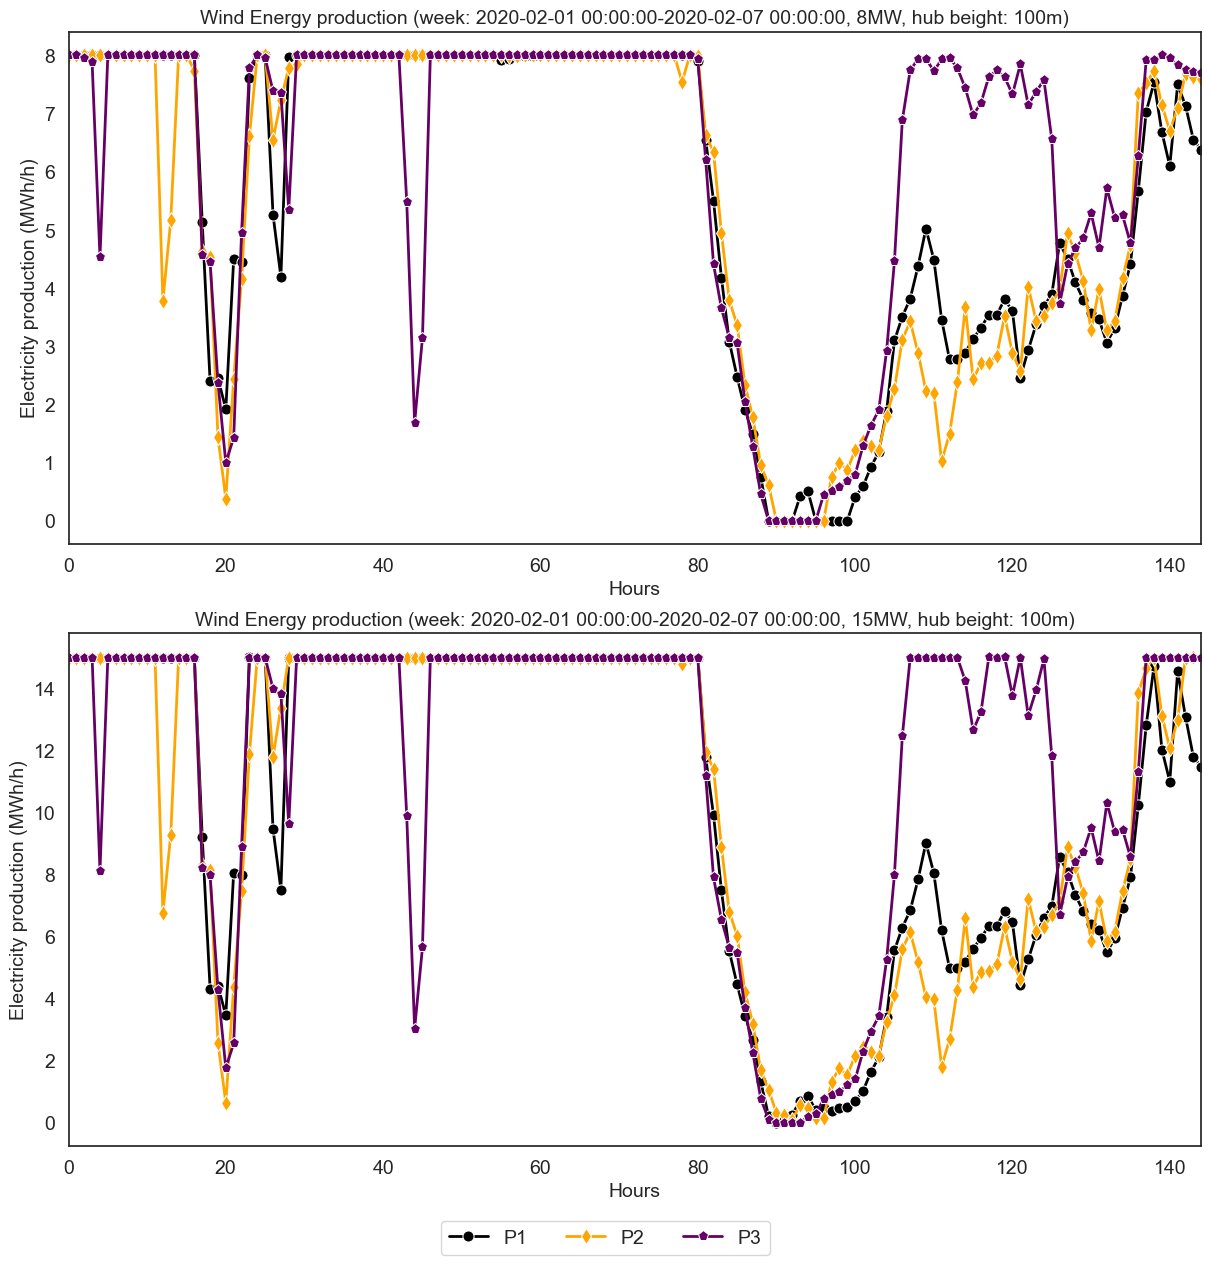

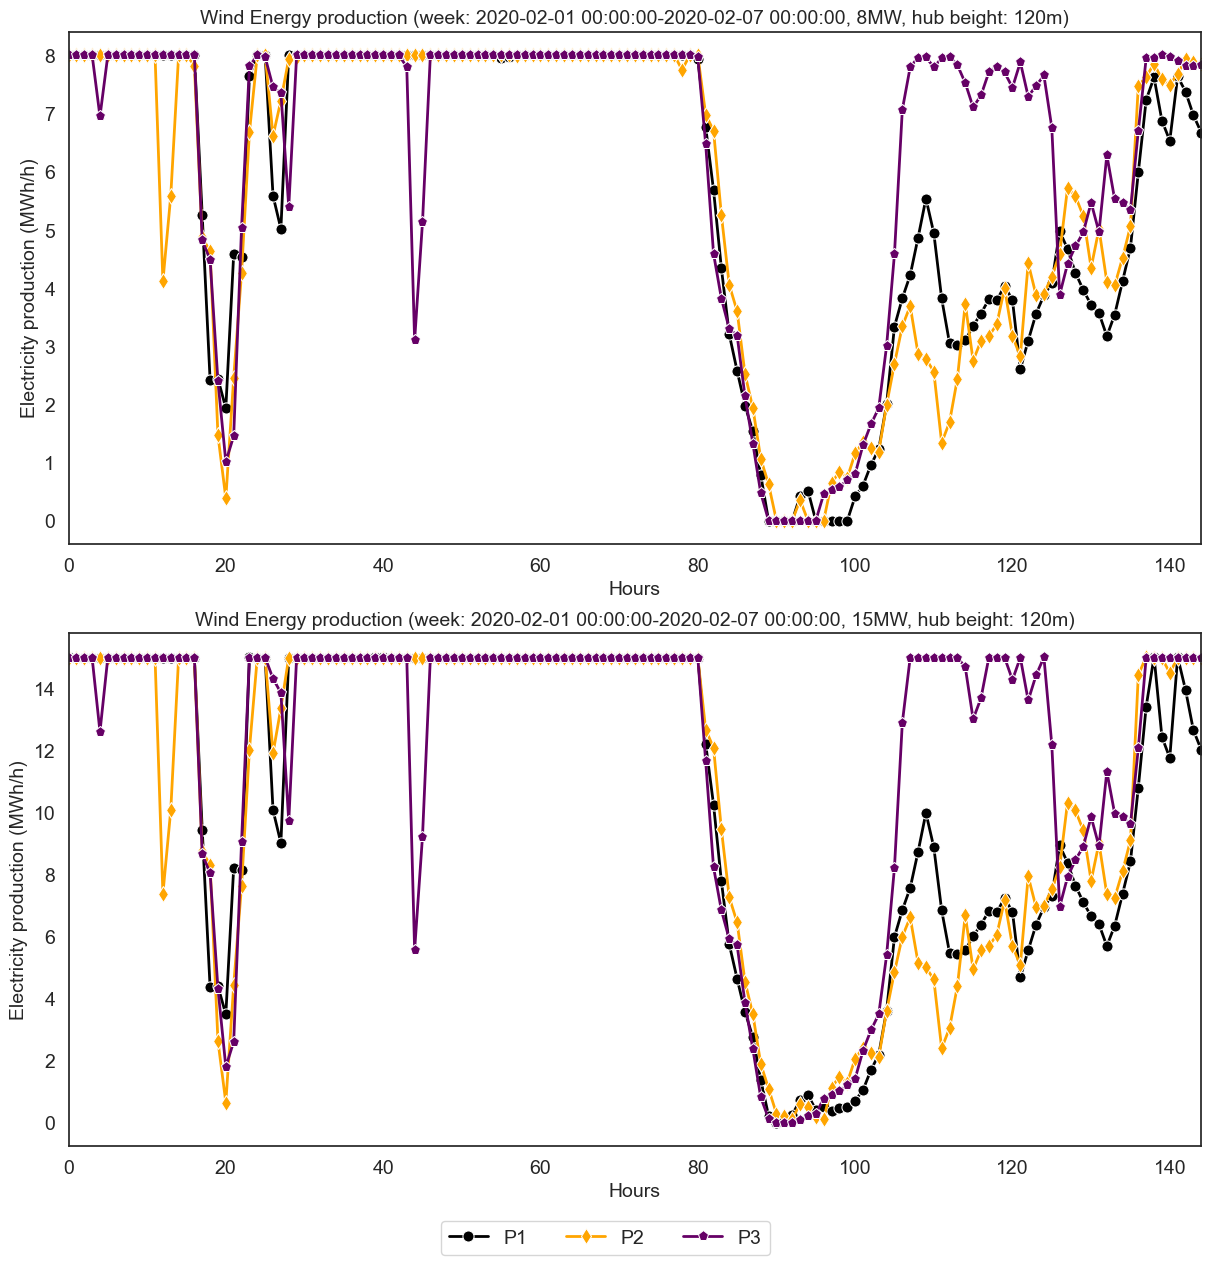

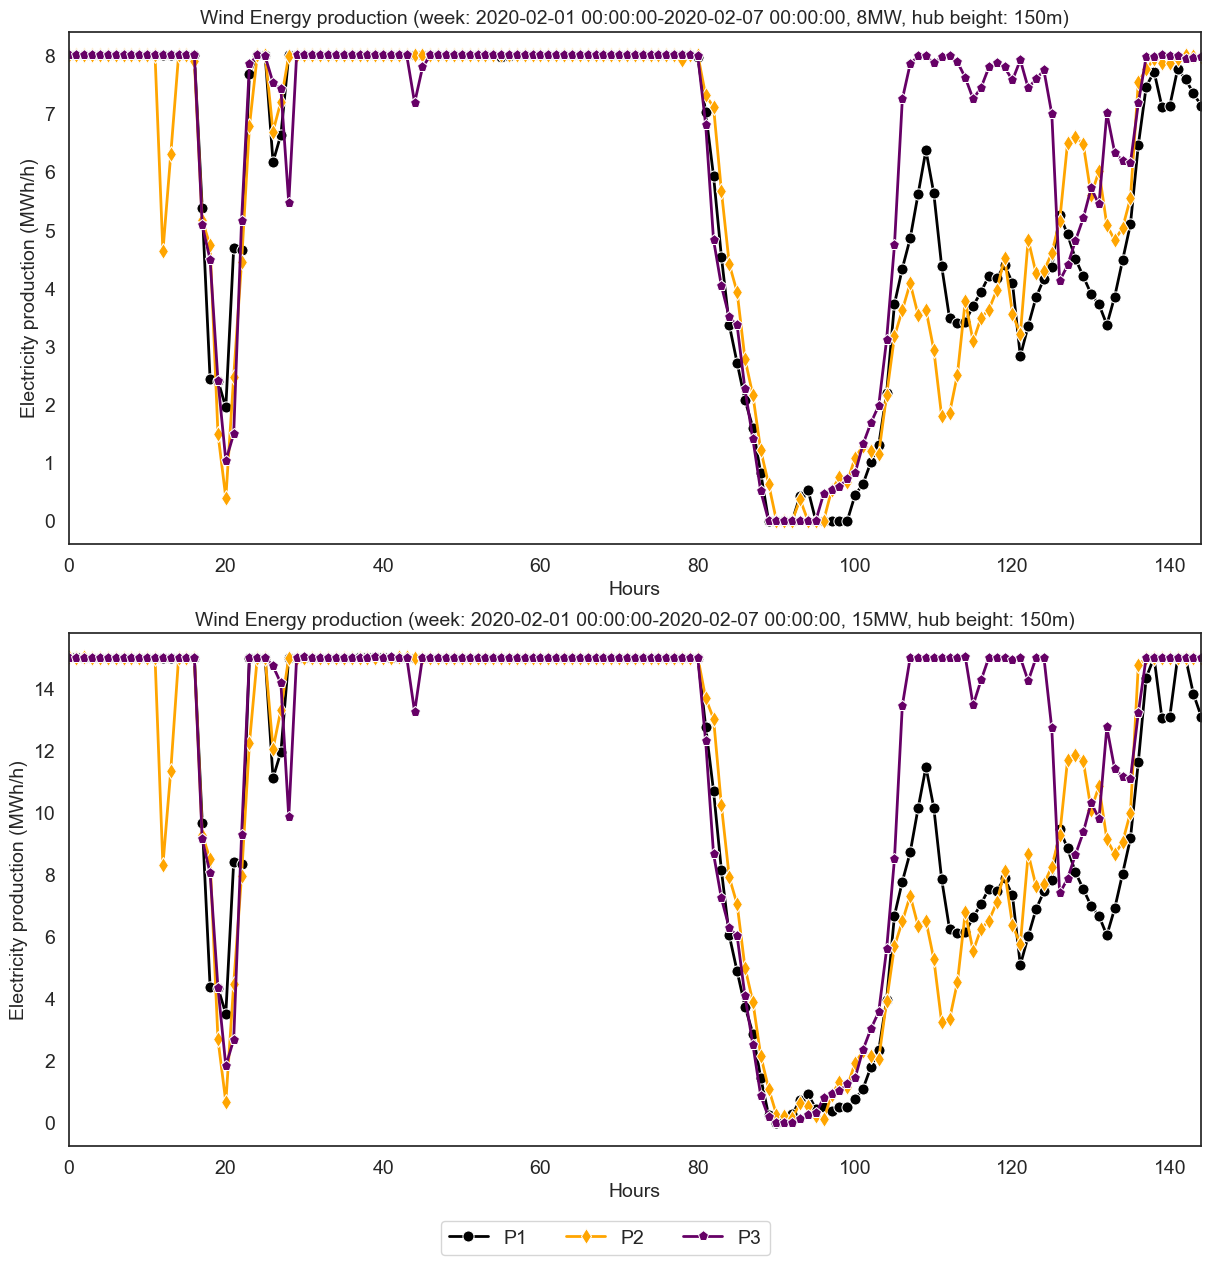

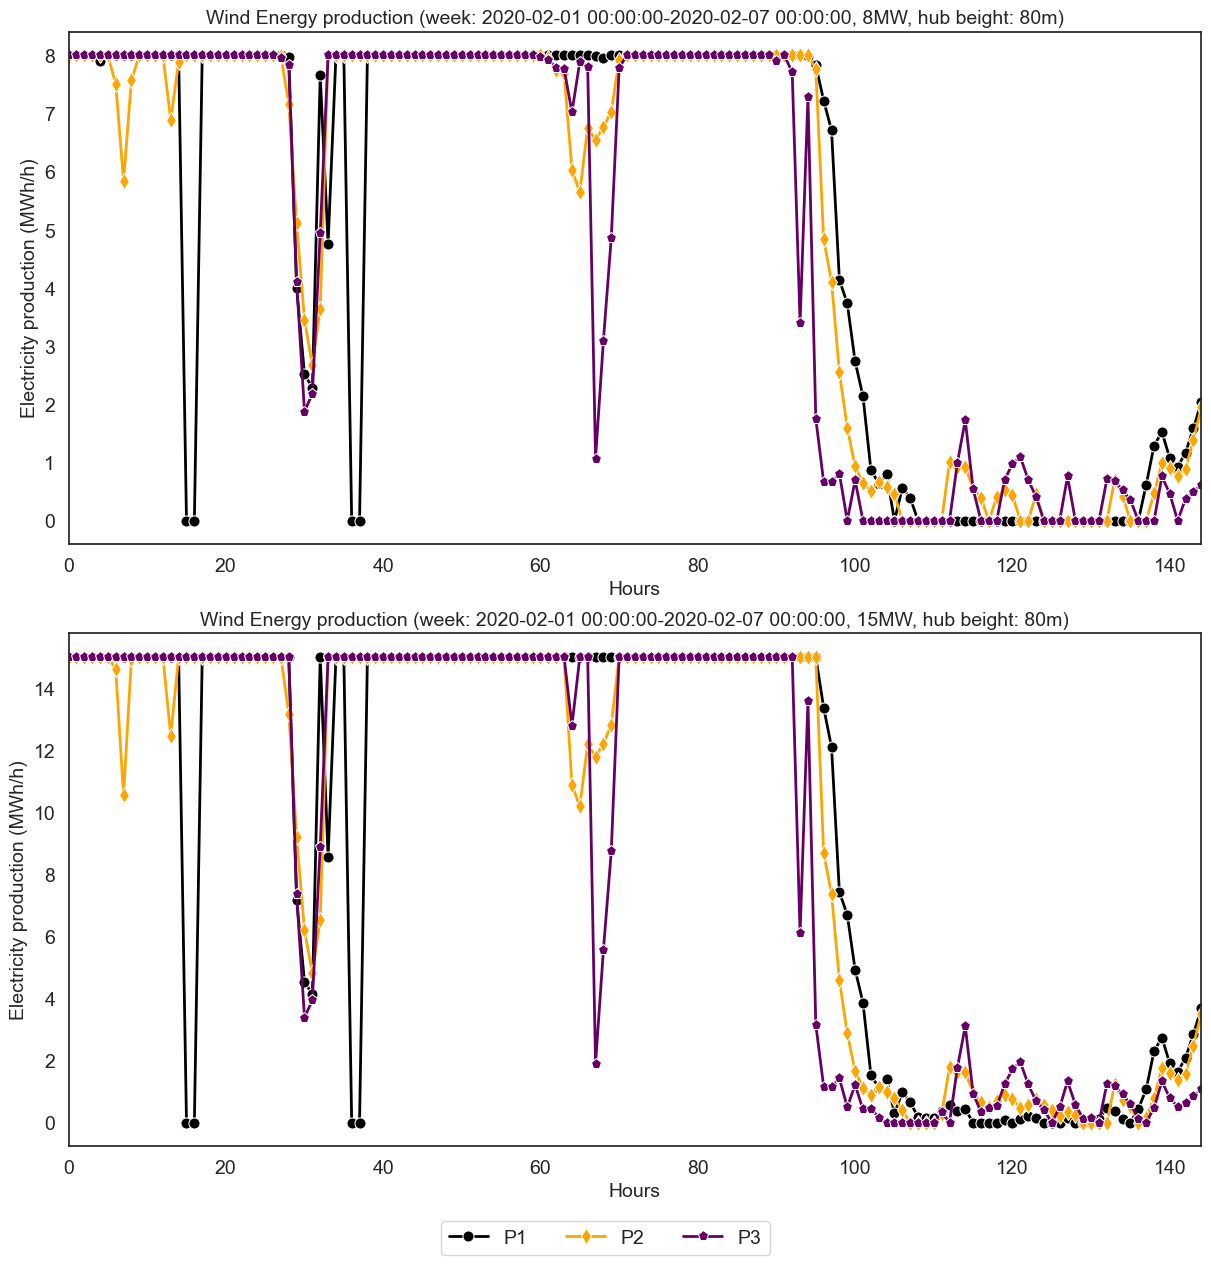

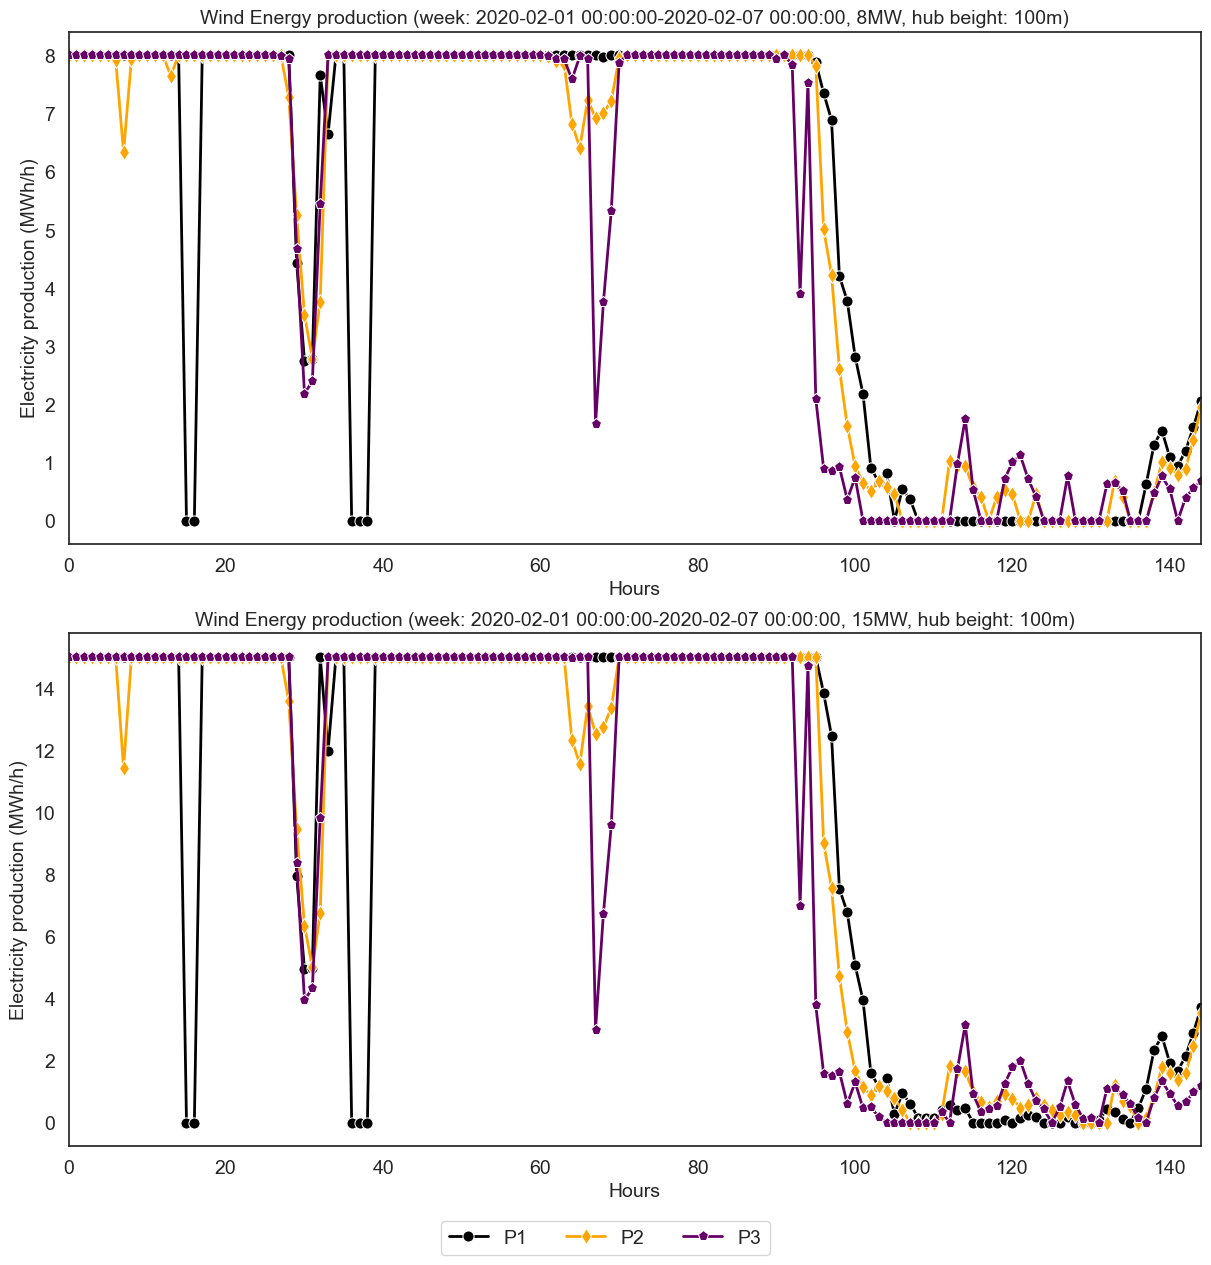

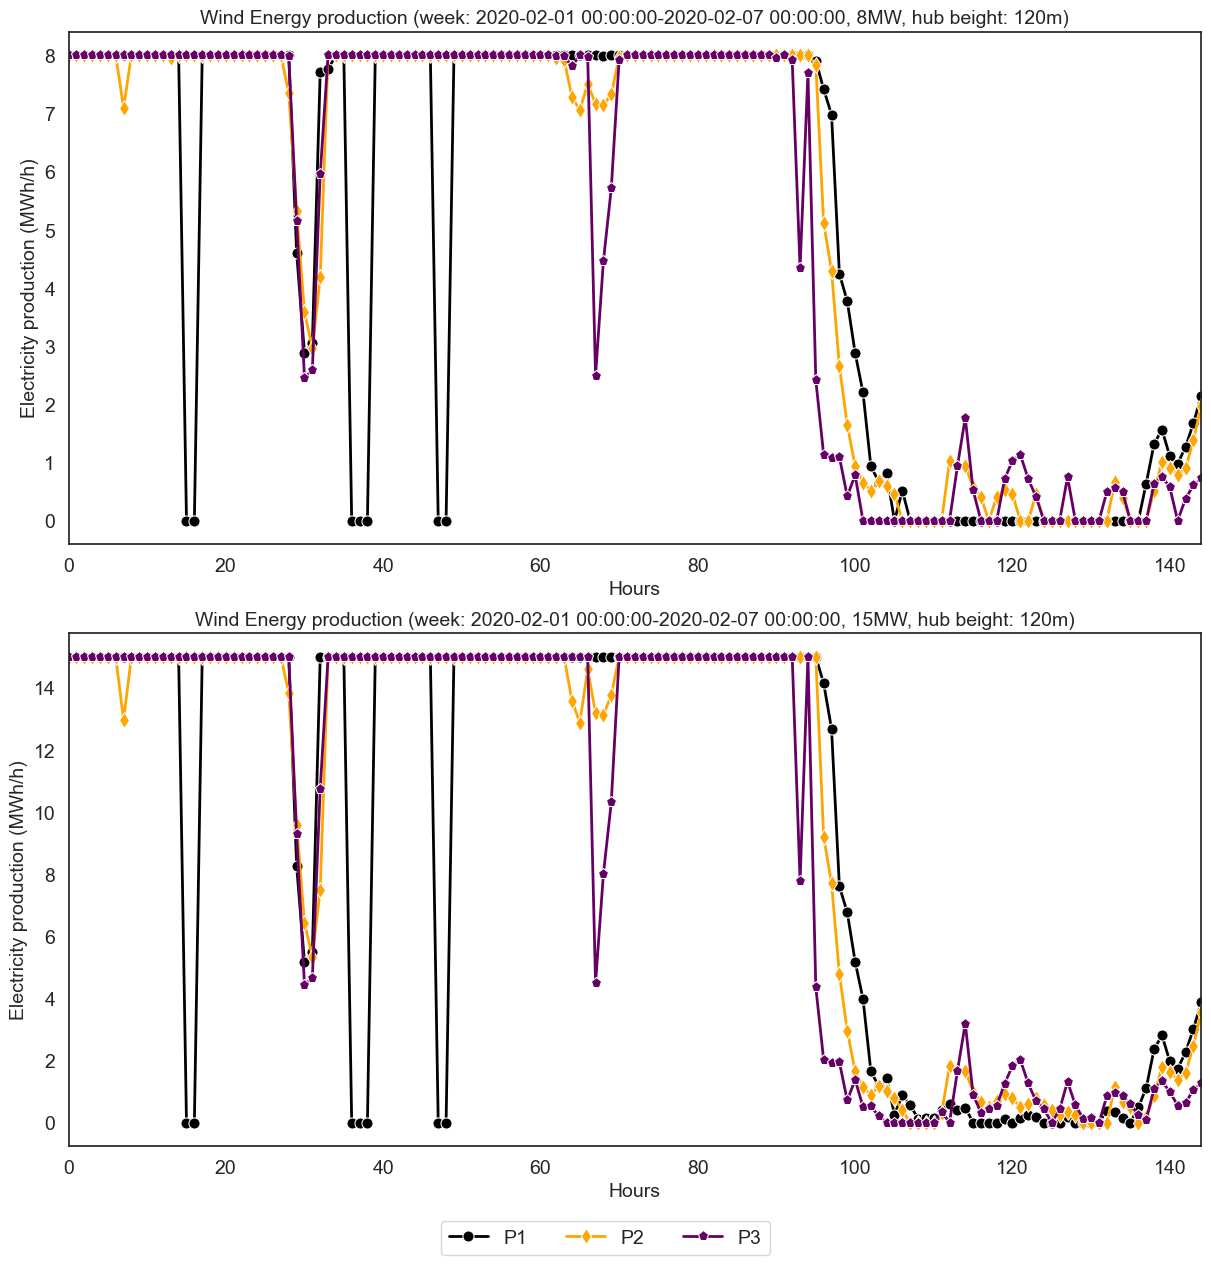

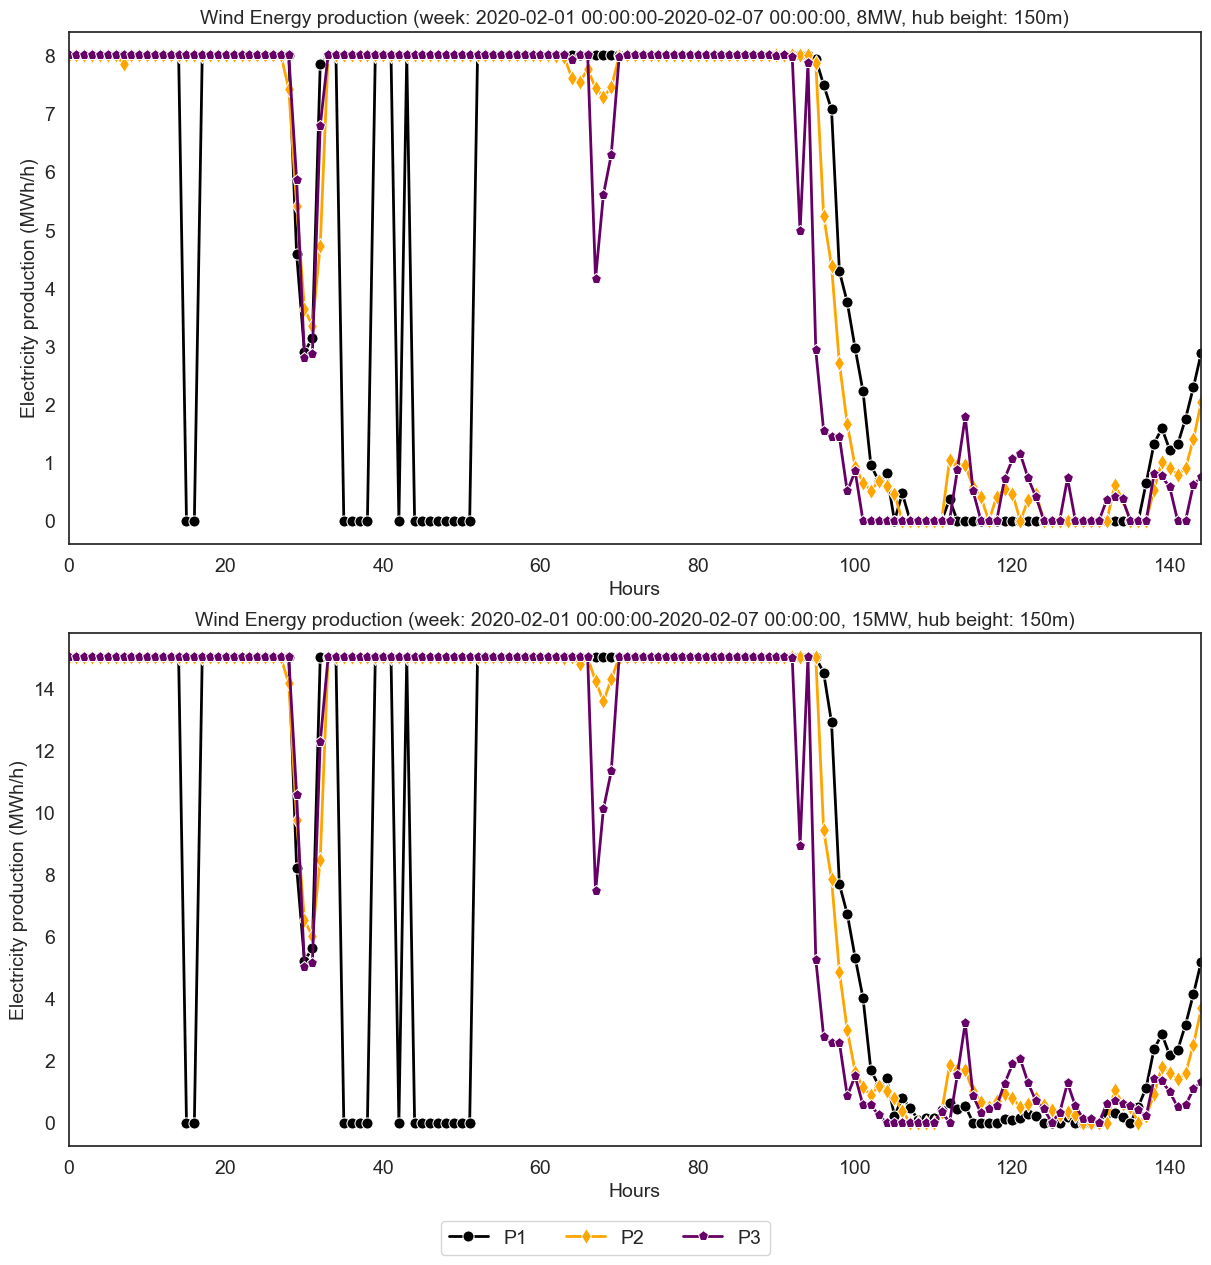

In [63]:
%%time
for case in ['Portugal_coast','Ireland_coast','Netherlands_coast']:
    run='New_runs'
    run_dir=f'{root_dir}/{run}/{case}/Postprocessed/variablewise_files'
    chunks={"Time": -1,"south_north": 8,"west_east": 8}
    sample_points = all_sample_points[case]
    for k,level in enumerate([80,100,120,150]):
        fig = plt.figure(figsize=(12, 12), constrained_layout=True)
        gs = fig.add_gridspec(2,1)
        sns.set_theme(style="white")

        for j,turbine_type in enumerate(['8MW','15MW']):
            tp = xr.open_dataset(f'{run_dir}/{turbine_type}/tp_{level}.nc',chunks=chunks)['power'].sel(Time=slice(start,end))

            hourly_df = pd.DataFrame()
            for i,key in enumerate(sample_points.keys()):
                ds = read_pointwise_timeseries(tp,sample_points[key][0],sample_points[key][1])/1e3
                pointwise_df = pd.DataFrame({key: ds},index=pd.Index(np.arange(len(ds)), name='Hour'))
                hourly_df = pd.concat([hourly_df, pointwise_df],axis=1)

            axs = power_profile_plotter(gs[j,0],hourly_df,
                                  f'Wind Energy production (week: {start}-{end}, {turbine_type}, hub beight: {level}m)','Hours','Electricity production (MWh/h)', 
                                  key,colors[i],'o')

        # Extract legend from one of the subplots
        handles, labels = axs.get_legend_handles_labels()
        # Create a common legend below the figures
        fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05),fontsize=14)

        plt.savefig(f'{case}_wind_energy_production_{level}m.png',dpi=300,bbox_inches='tight',pad_inches=0)

Time elapsed for nearest point identification is 0.004924297332763672s
{'south_north': 26, 'west_east': 79}
Time elapsed for nearest point identification is 0.010861635208129883s
{'south_north': 64, 'west_east': 54}
Time elapsed for nearest point identification is 0.011383533477783203s
{'south_north': 102, 'west_east': 31}
Time elapsed for nearest point identification is 0.004893779754638672s
{'south_north': 24, 'west_east': 45}
Time elapsed for nearest point identification is 0.011121511459350586s
{'south_north': 89, 'west_east': 77}
Time elapsed for nearest point identification is 0.010625600814819336s
{'south_north': 100, 'west_east': 25}
Time elapsed for nearest point identification is 0.004860639572143555s
{'south_north': 78, 'west_east': 18}
Time elapsed for nearest point identification is 0.009914875030517578s
{'south_north': 142, 'west_east': 59}
Time elapsed for nearest point identification is 0.009872198104858398s
{'south_north': 175, 'west_east': 146}
CPU times: user 12 s, s

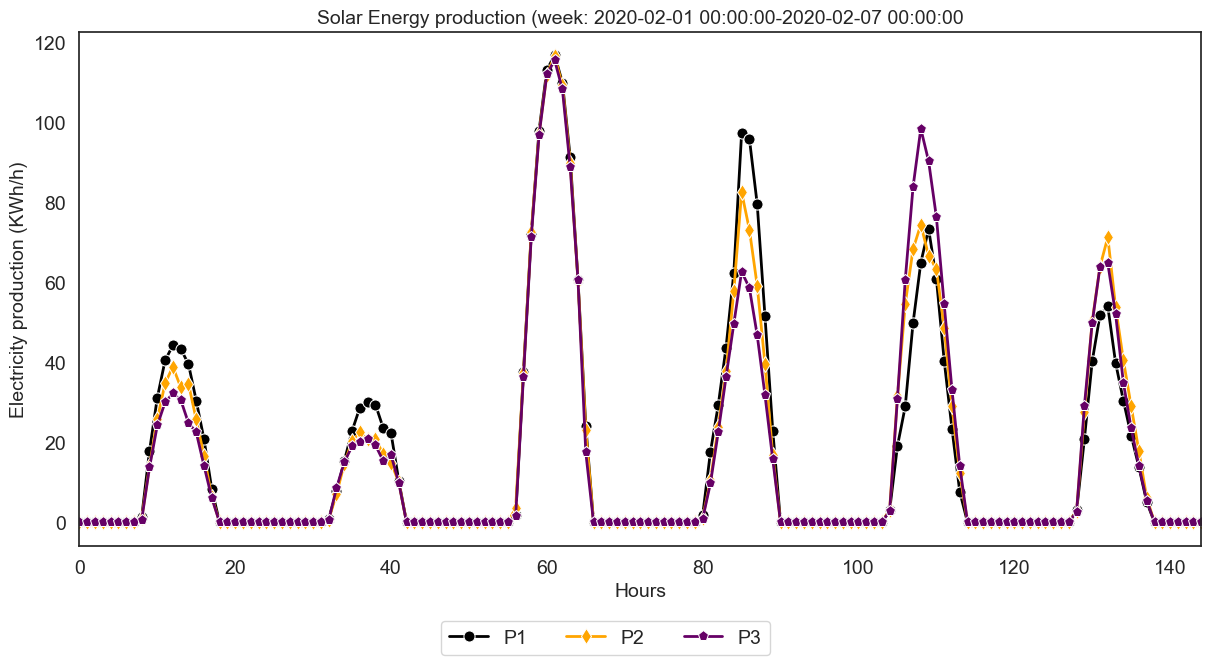

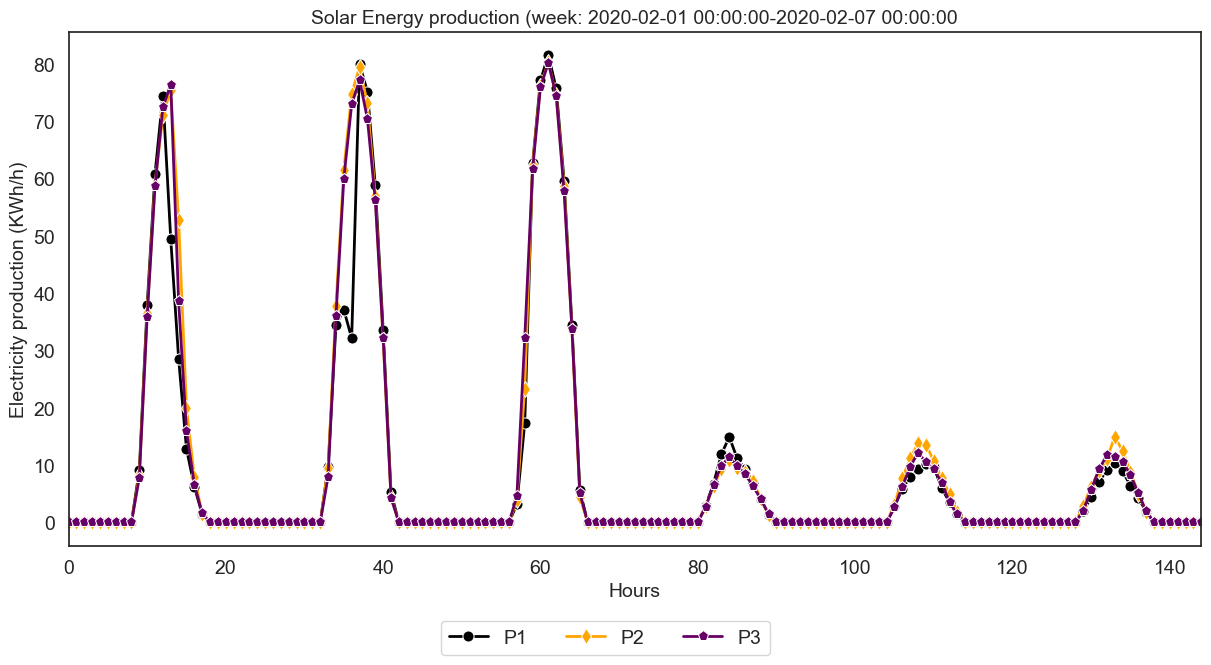

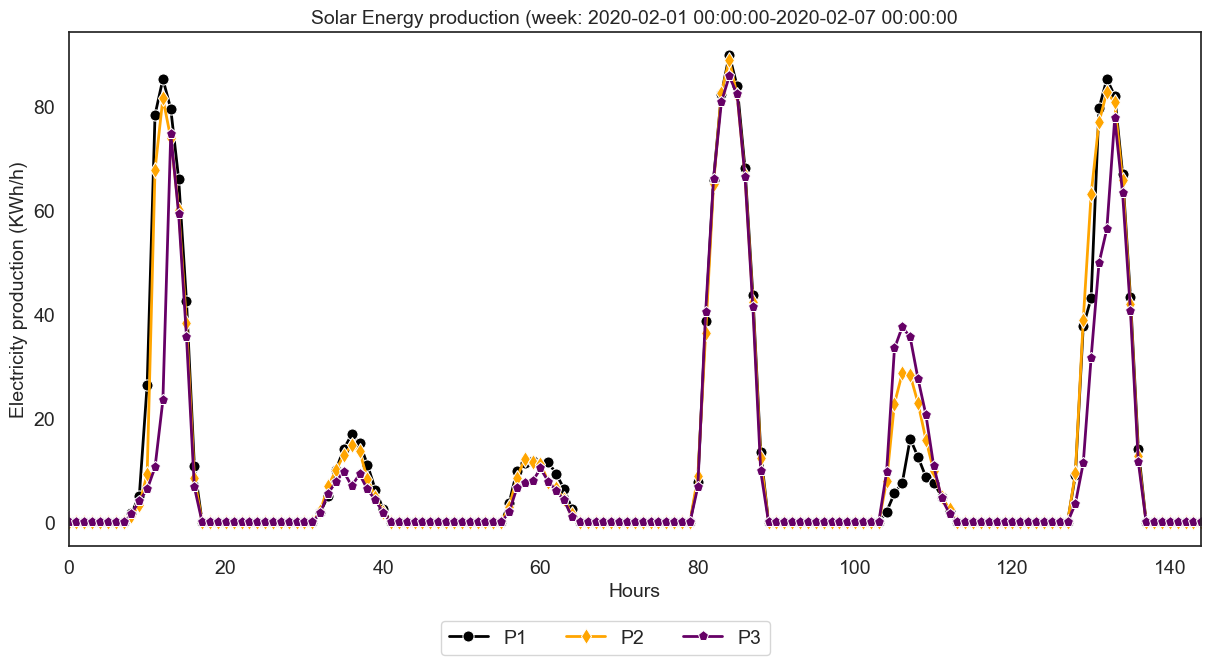

In [73]:
%%time
for case in ['Portugal_coast','Ireland_coast','Netherlands_coast']:
    run='New_runs'
    run_dir=f'{root_dir}/{run}/{case}/Postprocessed/variablewise_files'
    chunks={"Time": -1,"south_north": 8,"west_east": 8}
    sample_points = all_sample_points[case]
    
    fig = plt.figure(figsize=(12, 6), constrained_layout=True)
    gs = fig.add_gridspec(1,1)
    sns.set_theme(style="white")

    spv = xr.open_dataset(f'{root_dir}/{run}/{case}/Postprocessed/variablewise_files/spv.nc',chunks=chunks)['PVO'].sel(Time=slice(start,end))

    hourly_df = pd.DataFrame()
    for i,key in enumerate(sample_points.keys()):
        ds = read_pointwise_timeseries(spv,sample_points[key][0],sample_points[key][1])
        pointwise_df = pd.DataFrame({key: ds},index=pd.Index(np.arange(len(ds)), name='Hour'))
        hourly_df = pd.concat([hourly_df, pointwise_df],axis=1)

    axs = power_profile_plotter(gs[0,0],hourly_df,
                          f'Solar Energy production (week: {start}-{end}','Hours','Electricity production (KWh/h)', 
                          key,colors[i],'o')

    # Extract legend from one of the subplots
    handles, labels = axs.get_legend_handles_labels()
    # Create a common legend below the figures
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.1),fontsize=14)

    plt.savefig(f'{case}_solar_energy_production.png',dpi=300,bbox_inches='tight',pad_inches=0)